In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import matplotlib
%matplotlib inline

In [30]:
def loadDataSet():
    df = pd.read_table("/home/galaxy/project/logistic_regression/new/LR_total_clinical.txt")
    df_pa = df[df['Label'] == 1]
    label_pa = df_pa['Label'].tolist()
    df_pa = df_pa.iloc[:, 1:]
    df_pa = df_pa.fillna(df_pa.mean())
    # 
    df_con = df[df['Label'] == 0]
    label_con = df_con['Label'].tolist()
    df_con = df_con.iloc[:, 1:]
    df_con = df_con.fillna(df_con.mean())
    dataMat = pd.concat([df_pa,df_con])
    labelMat = label_pa + label_con
    print(dataMat.head())
    return dataMat, labelMat

X,Y = loadDataSet()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0) # 
names = X_train.columns

   cirScore   Age  Cesarean  Abortion        BMI
0  1.178834  32.0       1.0       0.0  21.500000
1  0.357137  32.0       0.0       0.0  19.979188
2  0.027371  34.0       1.0       1.0  18.750000
3  1.924940  32.0       0.0       0.0  23.147255
4  0.253291  32.0       1.0       0.0  19.500000


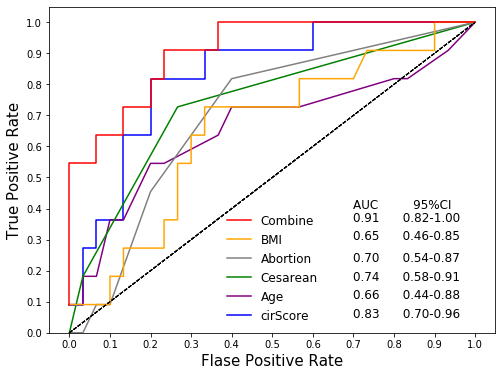

In [24]:
### combine with clinical measure
f,ax = plt.subplots(figsize=(8,6))
color_list = ['blue','purple', 'green', 'grey', 'orange', 'red']
legend_list = ['cirScore', 'Age', 'Cesarean', 'Abortion', 'BMI', 'Combine']
X_clin = [X_test[x] for x in legend_list[:-1]] ### 
train_list = X_clin + [X_test]  ### 
height_list = [0.05, 0.11, 0.17, 0.23, 0.3, 0.36]
#####
for i in range(len(train_list)):
    classfier = LogisticRegression()
    sc = StandardScaler()
    if i == 5:
        i_train = train_list[i]
    else:
        i_train = [[x] for x in train_list[i]]
    i_train = sc.fit_transform(i_train)
    classfier.fit(i_train, Y_test) ### 
    y_score = classfier.predict_proba(i_train)[:,1]
    fpr,tpr,threshold = metrics.roc_curve(Y_test, y_score) ### 
    roc_auc = metrics.auc(fpr,tpr)
    plt.stackplot(fpr, tpr, color='white', alpha = 0.5, edgecolor = 'black')
    plt.plot(fpr, tpr, color=color_list[i], lw = 1.5, label=legend_list[i])
    plt.plot([0,1],[0,1], color = 'black', linestyle = '--', lw = 1)
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("Flase Positive Rate", fontsize=15)
    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)
    # 
    ci = calculate_ci(Y_test, y_score) ### 
    plt.text(0.7,height_list[i],'%0.2f      %0.2f-%0.2f' % (roc_auc, ci[0], ci[1]), fontsize=12)
    plt.legend(loc='lower center', fontsize=12,frameon=False)
plt.text(0.7,0.4,'AUC         95%CI', fontsize=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='lower center', fontsize=12, frameon=False)
plt.show()
#
result_dir = "/home/galaxy/project/logistic_regression/new/"
res = os.path.join(result_dir, "ROC_clinvar_test.pdf")  ### 
f.savefig(res, bbox_inches='tight')

In [31]:
# Standard scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
X = sc.fit_transform(X)

In [32]:
# classfier = LogisticRegression()
# classfier.fit(X_train, Y_train)
# coef, intercept = classfier.coef_[0], classfier.intercept_[0]

# print("cirScore=%fxExp(%s) + %fxExp(%s) + %fxExp(%s) + %fxExp(%s) + (%f)" % 
#      (coef[0],names[0],coef[1],names[1],coef[2],names[2],coef[3],names[3],intercept))
### ## for training cohort
# Y_pred = classfier.predict(X_train)
Y_pred = classfier.predict(X)
### ## predict for test set
#Y_pred = classfier.predict(X_test)
#print("Residual sum of squares: %.2f"% np.mean((classfier.predict(X_test) - Y_test) ** 2))
#print('Score: %.2f' % classfier.score(X_test, Y_test))

In [33]:
## for test cohort
# print(Y_train)
# print(Y_pred)
# tp = len([i for i in range(len(Y_train)) if (Y_train[i] == 1) and (Y_pred[i] == 1)])
# fn = len([i for i in range(len(Y_train)) if (Y_train[i] == 1) and (Y_pred[i] == 0)])
# tn = len([i for i in range(len(Y_train)) if (Y_train[i] == 0) and (Y_pred[i] == 0)])
# fp = len([i for i in range(len(Y_train)) if (Y_train[i] == 0) and (Y_pred[i] == 1)])
tp = len([i for i in range(len(Y)) if (Y[i] == 1) and (Y_pred[i] == 1)])
fn = len([i for i in range(len(Y)) if (Y[i] == 1) and (Y_pred[i] == 0)])
tn = len([i for i in range(len(Y)) if (Y[i] == 0) and (Y_pred[i] == 0)])
fp = len([i for i in range(len(Y)) if (Y[i] == 0) and (Y_pred[i] == 1)])
print(tp, fn, tn, fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp+tn)/(tp+fn+fp+tn)
print(sensitivity, specificity, accuracy)

34 7 88 6
0.8292682926829268 0.9361702127659575 0.9037037037037037


In [ ]:
def calculate_ci(Y_train, y_score):
    alpha = .95
    auc, auc_cov = delong_roc_variance(Y_train, y_score)
    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)
    ci = stats.norm.ppf(lower_upper_q, loc=auc, scale=auc_std)
    ci[ci > 1] = 1
    # print('AUC:', auc)
    # print('AUC COV:', auc_cov)
    # print('95% AUC CI:', ci)
    return ci

In [4]:
import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    # order = (-ground_truth).argsort()
    order = np.negative(ground_truth).argsort()
    # label_1_count = int(ground_truth.sum())
    label_1_count = int(sum(ground_truth))
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov

In [13]:
#################################### R code for pROC package ##############################################
# print(Y_train)
# print(",".join([str(x) for x in y_score]))
# print(len(Y_train), len(y_score))
# calculate confidence interval
# library(pROC)
# y_true = c(0,    1,    0,    0,    1,    1,    0,    1,    0)
# y_pred = c(0.21, 0.32, 0.63, 0.35, 0.92, 0.79, 0.82, 0.99, 0.04)
# # Build a ROC object and compute the AUC
# roc = roc(y_true, y_pred)
# roc
# ci(roc)
# 95% CI: 0.8355-0.9838